In [1]:
import os
import cv2
import gc
import numpy as np

from scipy.optimize import curve_fit
from obspy import UTCDateTime
from pandas import DataFrame, date_range

import matplotlib.pyplot as plt

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

In [3]:
config = {}

config['path_to_data'] = data_path+"ids/cut/"

config['path_to_outdata'] = data_path+"ids/data/"

config['date1'] = "2024-01-29"
config['date2'] = "2024-02-05"


In [4]:
def twoD_Gaussian(xy, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):

    x, y = xy
    xo = float(xo)
    yo = float(yo)
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) + c*((y-yo)**2)))

    return g.ravel()

In [ ]:
from tqdm.notebook import tqdm



for _date in date_range(config['date1'], config['date2']):

    ## get date as str
    date_str = str(_date)[:10]

    path_to_data = f"{config['path_to_data']}{date_str.replace('-','')}/"

    ## read files in directory
    files = os.listdir(path_to_data)

    ## prepare lists
    times, x_idx, y_idx = [], [], []

    for _n, file in enumerate(tqdm(files[:20])):


        ## check data type
        if file[-3:] != "png":
            print(f" -> not a png: {file}")
            continue

        ## load image and get dimensions
        try:
            im = cv2.imread(path_to_data+file, -1)
            h, w = im.shape
            data = im.ravel()

        except:
            print(f" -> failed to load image: {file}")
            continue


        ## prepare x-y-mesh
        x = np.linspace(0, w, w)
        y = np.linspace(0, h, h)
        x, y = np.meshgrid(x, y)

        # initial guess of parameters [ amplitude, xo, yo, sigma_x, sigma_y, theta, offset ]
        initial_guess = (255, 900, 350, 50, 50, 0, 0)

        try:

            # find the optimal Gaussian parameters
            popt, pcov = curve_fit(twoD_Gaussian, (x, y), data, p0=initial_guess)

            # create new data with these parameters
            data_fitted = twoD_Gaussian((x, y), *popt)

        except:
            continue

        # reshape to image dimensions
        im_fitted = data_fitted.reshape(h, w)

        ## get maximum of 2d fit
        y_max, x_max = np.argwhere(im_fitted == im_fitted.max())[0]

        # print(UTCDateTime(file[4:12]+"T"+file[13:19]), y_max, x_max)

        times.append(str(UTCDateTime(file[4:12]+"T"+file[13:19])))
        y_idx.append(y_max)
        x_idx.append(x_max)


        if _n % 10 == 0:

            fig = plt.figure();

            plt.imshow(im, cmap=plt.get_cmap("gray"));
            plt.contour(x, y, im_fitted);
            plt.scatter(x_max, y_max, color="red", marker="d");

            fig.savefig(config['path_to_outdata']+"outfigs/"+f"{file[:-4]}_mod.png", format="png", dpi=150, bbox_inches='tight');

        _gc = gc.collect();

    ## prepare output dataframe
    df_out = DataFrame()

    df_out['time_local'] = times
    df_out['y_idx'] = y_idx
    df_out['x_idx'] = x_idx

    ## sort for time column
    df_out.sort_values(by="time_local", inplace=True)

    ## write output data frame
    df_out.to_pickle(config['path_to_outdata']+f"{date_str}.pkl")


# cv2.imwrite(r"path_to_save\data_fitted.png", data_fitted.reshape(h,w))

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

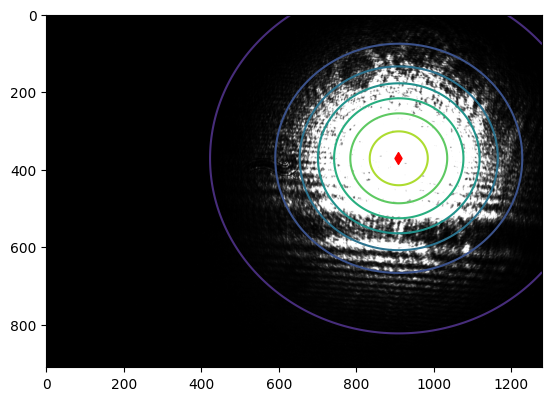

In [26]:
cmap = plt.get_cmap("gray")

y_max, x_max = np.argwhere(im_fitted == im_fitted.max())[0]

plt.imshow(im, cmap=cmap)
plt.contour(x, y, im_fitted)
plt.scatter(x_max, y_max, color="red", marker="d")

plt.show();
## End of File

# 